# Porject Name

Team:
1. Renee Dhanaraj
2. Aditi Verma
3. Chris Park
4. Aryan Ahuja

In [2]:
# sklearn imports
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, mean_squared_error, f1_score

# data manipulation imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


## Importing dataset

In [46]:
original_dataset_df = pd.read_csv('dataset/dataset.csv')
original_dataset_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Data Cleaning

In [106]:
# creating a copy to clean to avoid contamination of original data
df = original_dataset_df.copy()

In [107]:
# information about the dataset, such as number of entries, column names, non-null counts, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [108]:
# getting the summary statistics of the dataset (of numerical features)
df.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [109]:
# checking for missing values in each column
df.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [110]:
# dropping all the rows with any missing/null values since there are very few
df = df.dropna()
duplicates_mask_track_id = df["track_id"].duplicated()
print(duplicates_mask_track_id.sum())
# dropping unnecessary columns that won't help in prediction like id
df = df.drop(columns=["Unnamed: 0", "track_id"])

# IF WE PLAN TO NOT USE NLP FOR NATURAL LANGUAGE PROCESSING, UNCOMMENT AND DROP TEXT COLUMNS
# df = df.drop(columns=["artists", "album_name", "track_name", "track_genre"])

# making sure the "explicit" column is of type integer and not boolean
df["explicit"] = df["explicit"].astype(int)

24259


In [112]:
# sanity checks for the important numeric columns
print("Popularity range:", df["popularity"].min(), "to", df["popularity"].max())
print("Duration range (ms):", df["duration_ms"].min(), "to", df["duration_ms"].max())
print("Tempo range:", df["tempo"].min(), "to", df["tempo"].max())
print("Loudness range:", df["loudness"].min(), "to", df["loudness"].max())

# duplicate check
duplicates_mask = df.duplicated(subset=["artists", "album_name", "track_name"])
print("Number of duplicate entries based on artists, album_name, track_name:", duplicates_mask.sum())
df = df.drop_duplicates(subset=["artists", "album_name", "track_name"])
print(len(df))

Popularity range: 0 to 100
Duration range (ms): 8586 to 5237295
Tempo range: 0.0 to 243.372
Loudness range: -49.531 to 4.532
Number of duplicate entries based on artists, album_name, track_name: 24620
89379


In [113]:
# sanity checks for categorical columns
print("Explicit values:", df["explicit"].value_counts())
print("\nMode values:", df["mode"].value_counts())
print("\nTime signature values:", df["time_signature"].value_counts())
print("\nKey values:", df["key"].value_counts().sort_index())



Explicit values: explicit
0    81726
1     7653
Name: count, dtype: int64

Mode values: mode
1    56927
0    32452
Name: count, dtype: int64

Time signature values: time_signature
4    79220
3     7586
5     1575
1      838
0      160
Name: count, dtype: int64

Key values: key
0     10312
1      8535
2      9282
3      2759
4      7120
5      7288
6      6102
7     10505
8      5543
9      8972
10     5864
11     7097
Name: count, dtype: int64


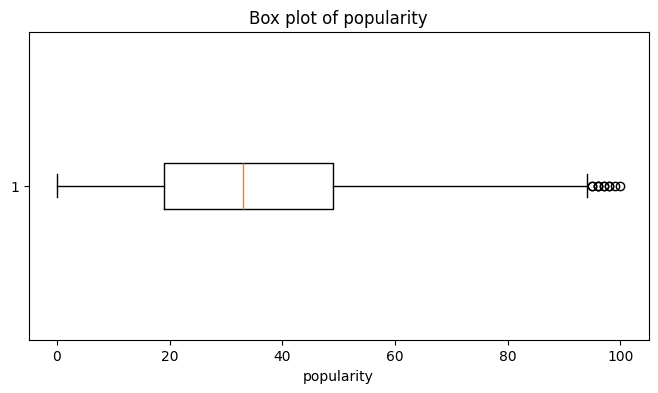

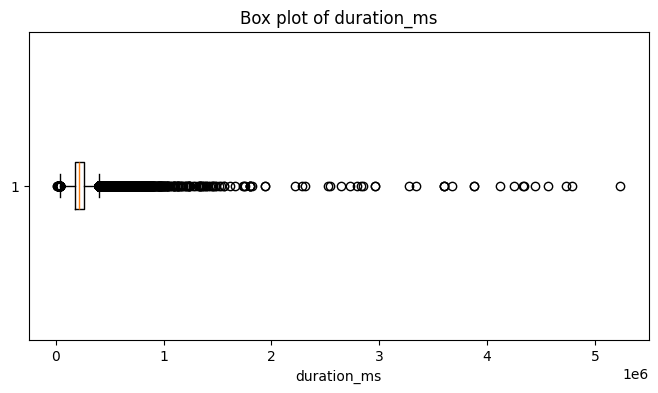

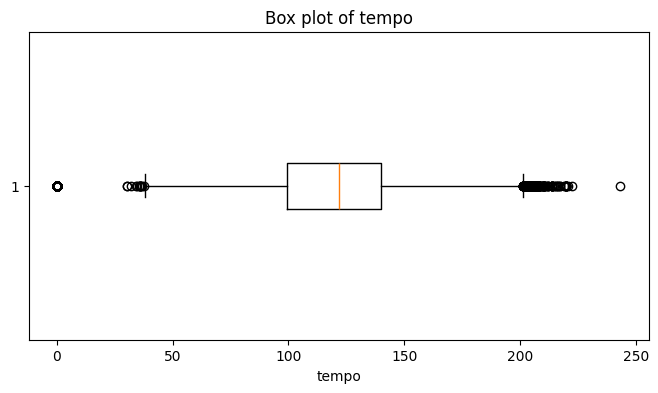

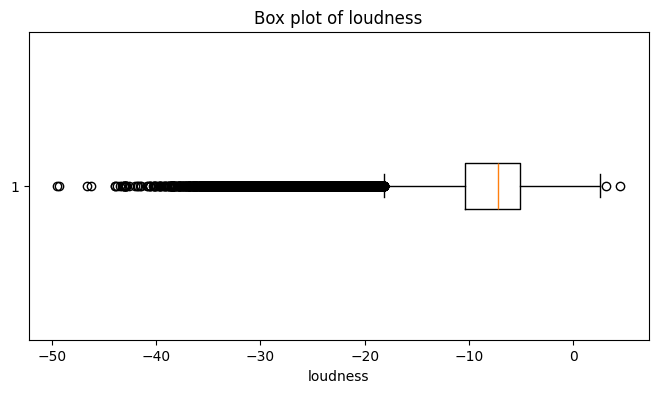

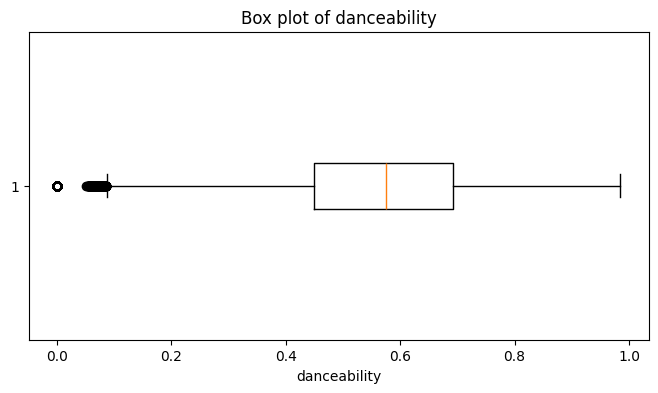

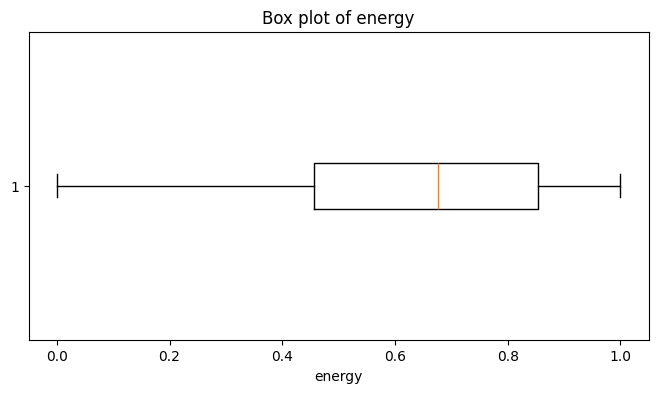

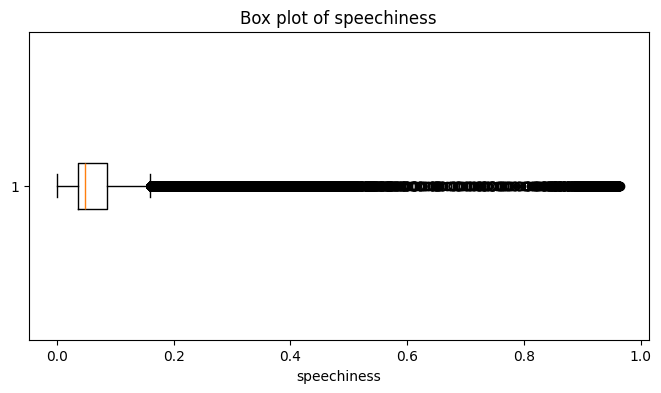

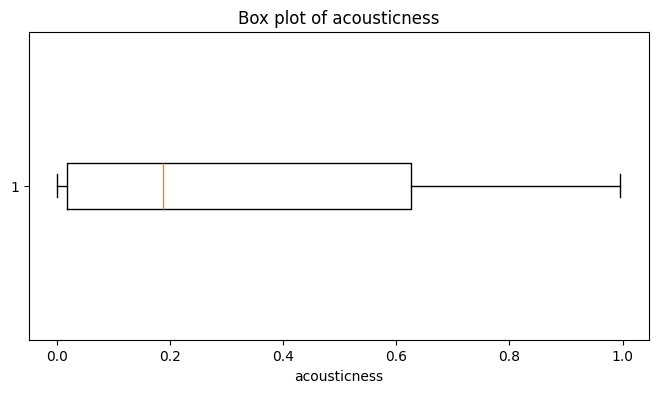

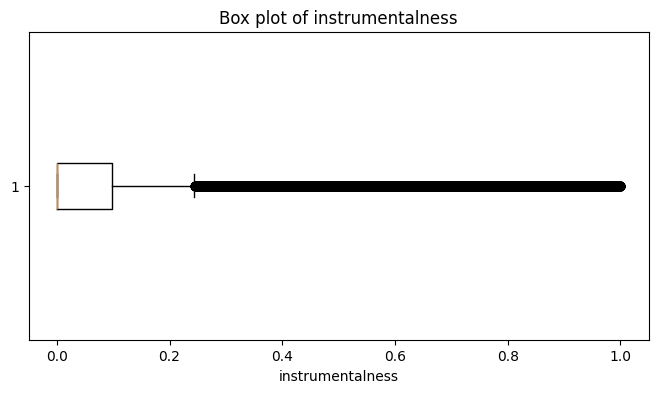

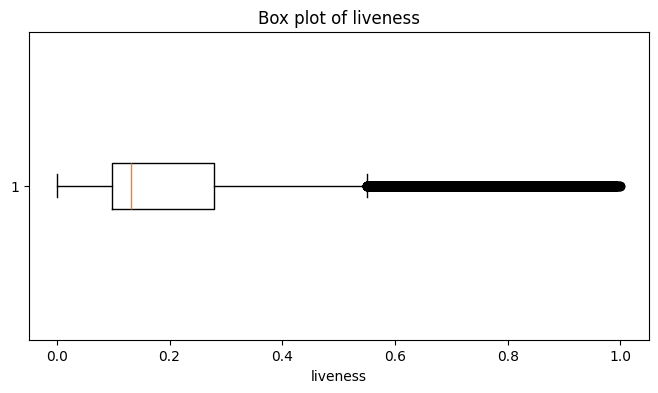

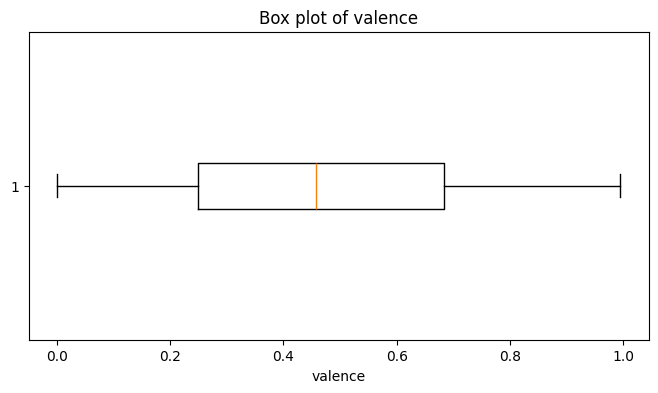

In [114]:
# checking for outliers in numerical columns using box plots
numerical_columns = ["popularity", "duration_ms", "tempo", "loudness", "danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Box plot of {col}')
    plt.xlabel(col)
    plt.show()

# We can see that some features are skewer, but if we train models like XGBoost, for ensemble methods, we need not do any transformations
# There are some outliers as well, but we still need to keep them since they are real songs and removing them would lead to loss of information
# Hence, we will not be doing any outlier removal or transformations for skewness at this point

# If required for training (linear models or nerual networks), we can always do log transformations or apply standardization/normalization later

In [115]:
df.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [116]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 89379 entries, 0 to 113999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artists           89379 non-null  object 
 1   album_name        89379 non-null  object 
 2   track_name        89379 non-null  object 
 3   popularity        89379 non-null  int64  
 4   duration_ms       89379 non-null  int64  
 5   explicit          89379 non-null  int64  
 6   danceability      89379 non-null  float64
 7   energy            89379 non-null  float64
 8   key               89379 non-null  int64  
 9   loudness          89379 non-null  float64
 10  mode              89379 non-null  int64  
 11  speechiness       89379 non-null  float64
 12  acousticness      89379 non-null  float64
 13  instrumentalness  89379 non-null  float64
 14  liveness          89379 non-null  float64
 15  valence           89379 non-null  float64
 16  tempo             89379 non-null  float64
 1

artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

## Exploratory Data Analysis (EDA)

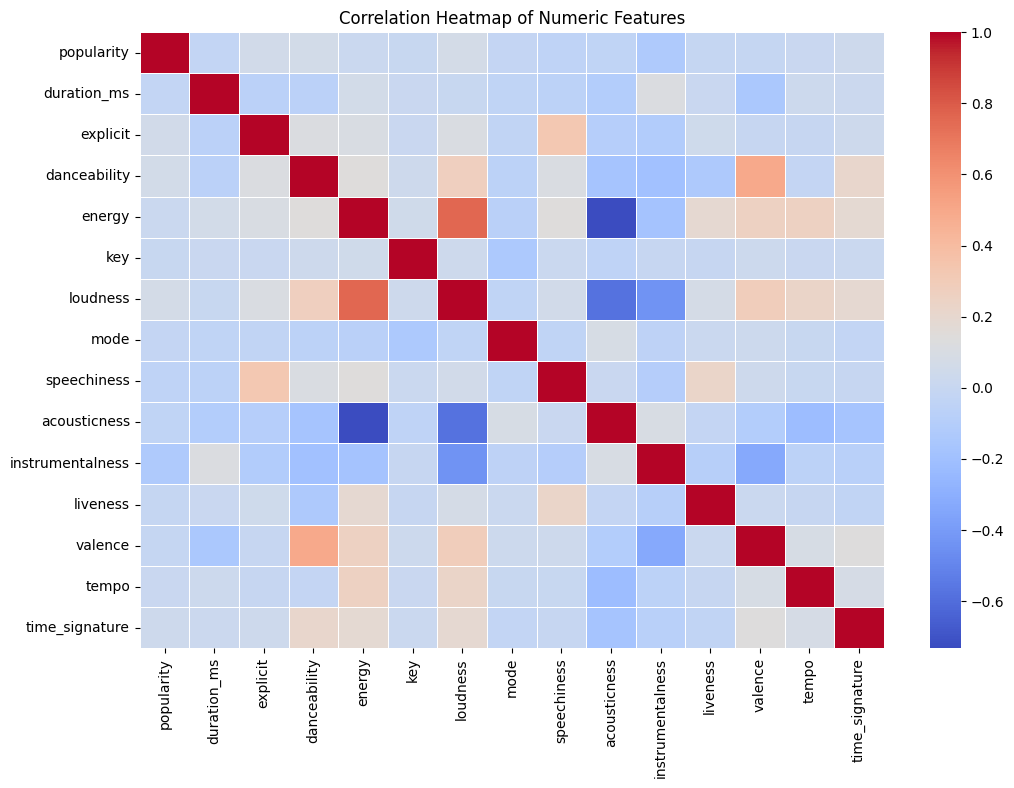

' OBSERVATIONS:\nGenerally a lot more negative corrolation than positive ones.\n\nSong Type\n    Negative corrolation: \n        energy + acousticness\n        loudness + acousticness\n        loudness + instrumentalness\n        valence + instrumentalness\n\n    Positive corrolation:\n        loudness + energy\n        loudness + danceability\n        danceability + valence\n        energy + valence\n        speechiness + explicit\n\nPopularity\n    Negative corrolation:\n        popularity + instrumentalness\n        popularity + duration_ms\n\n    No positive corrolation :((\n'

In [117]:
#attempt visualizing a headmap 
#use only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

#compute correlation matrix
corr = numeric_df.corr()

#plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

""" OBSERVATIONS:
Generally a lot more negative corrolation than positive ones.

Song Type
    Negative corrolation: 
        energy + acousticness
        loudness + acousticness
        loudness + instrumentalness
        valence + instrumentalness
    
    Positive corrolation:
        loudness + energy
        loudness + danceability
        danceability + valence
        energy + valence
        speechiness + explicit

Popularity
    Negative corrolation:
        popularity + instrumentalness
        popularity + duration_ms

    No positive corrolation :((
"""

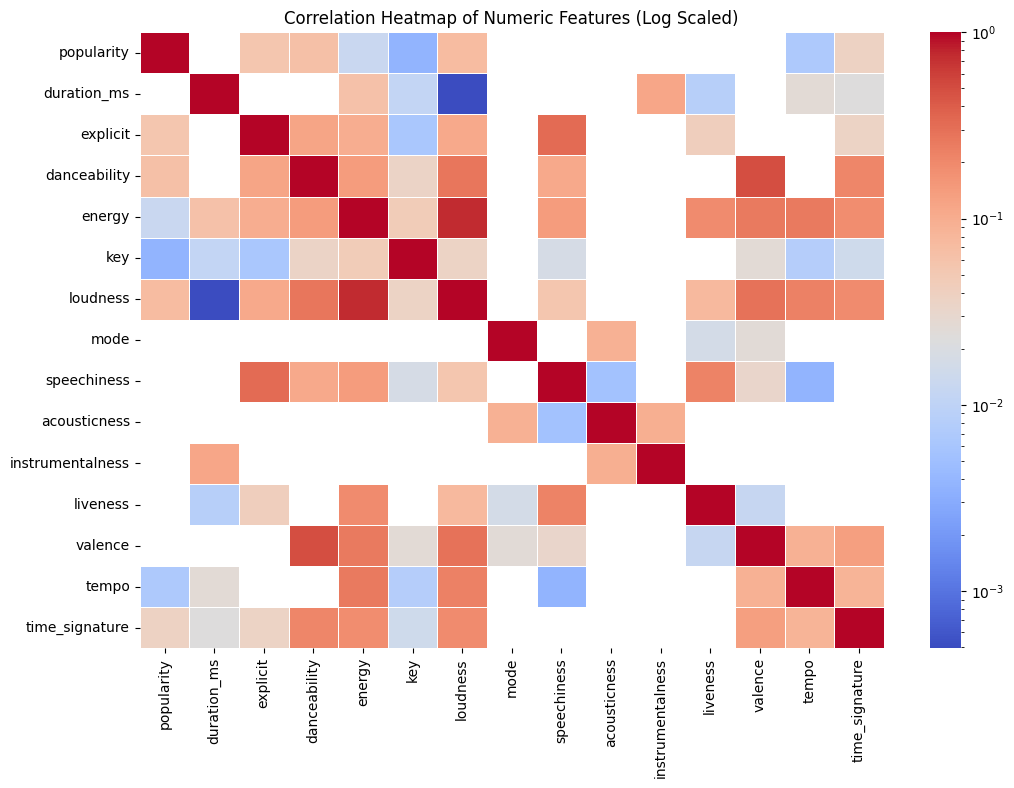

' OBSERVATIONS:\nGenerally a lot more positive corrolations\n\nPopularity\n    Negative corrolation:\n        energy\n        tempo\n\n    Positive corrolation:\n        explicit\n        danceability\n        loudness\n        time_signature\n\n'

In [118]:
# Try normalizing using log_scale to address highly skewed datasets
plt.figure(figsize=(12, 8))
sns.heatmap(corr, norm=mcolors.LogNorm(), cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features (Log Scaled)")
plt.show()

""" OBSERVATIONS:
Generally a lot more positive corrolations

Popularity
    Negative corrolation:
        energy
        tempo

    Positive corrolation:
        explicit
        danceability
        loudness
        time_signature
        
"""
# dig deeper into the significant corrolations

##### More EDA that is related to popularity

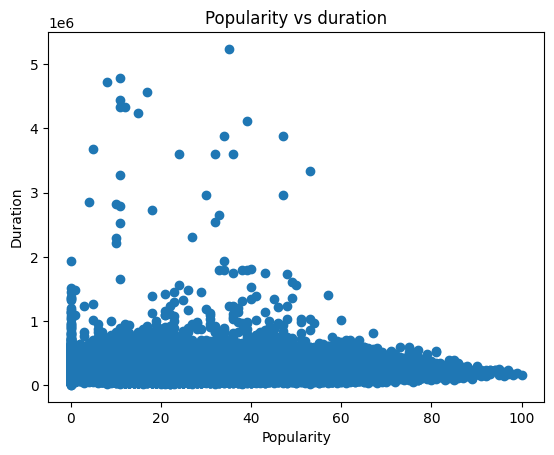

In [119]:
plt.scatter(df["popularity"], df["duration_ms"])
plt.xlabel("Popularity")
plt.ylabel("Duration")
plt.title("Popularity vs duration")
plt.show()
# df["duration"]

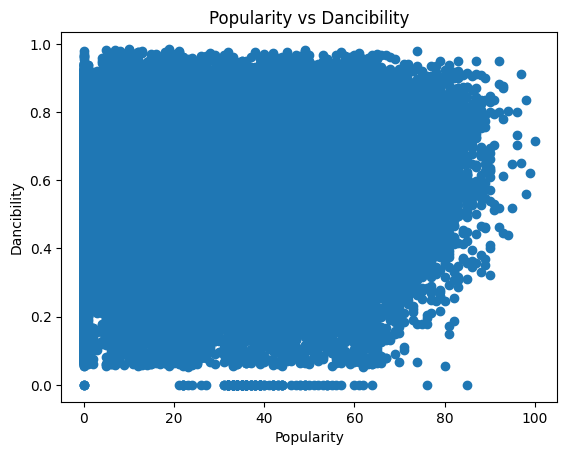

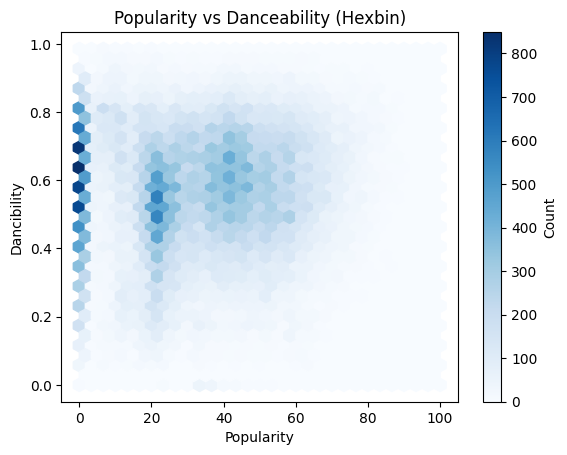

In [120]:
plt.scatter(df["popularity"], df["danceability"])
plt.xlabel("Popularity")
plt.ylabel("Dancibility")
plt.title("Popularity vs Dancibility")
plt.show()

plt.hexbin(df["popularity"], df["danceability"], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel("Popularity")
plt.ylabel("Dancibility")
plt.title("Popularity vs Danceability (Hexbin)")
plt.show()

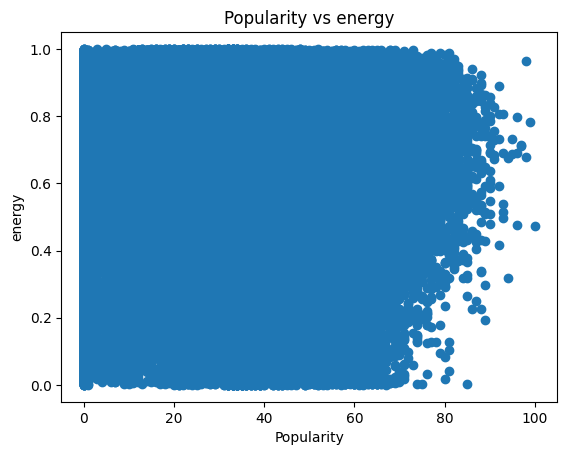

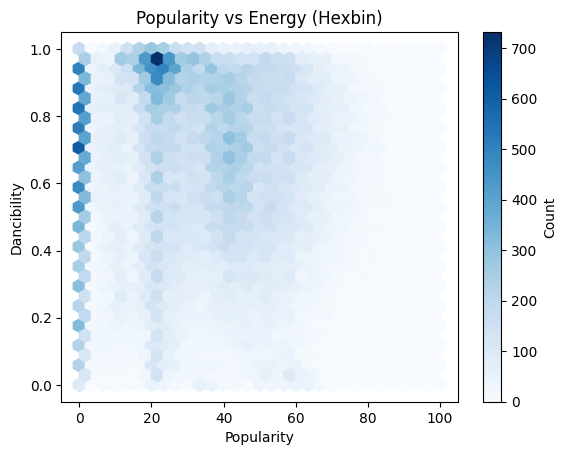

In [121]:
plt.scatter(df["popularity"], df["energy"])
plt.xlabel("Popularity")
plt.ylabel("energy")
plt.title("Popularity vs energy")
plt.show()

plt.hexbin(df["popularity"], df["energy"], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel("Popularity")
plt.ylabel("Dancibility")
plt.title("Popularity vs Energy (Hexbin)")
plt.show()

Text(0.5, 1.0, 'Acustic distribution for songs with >50 popularity')

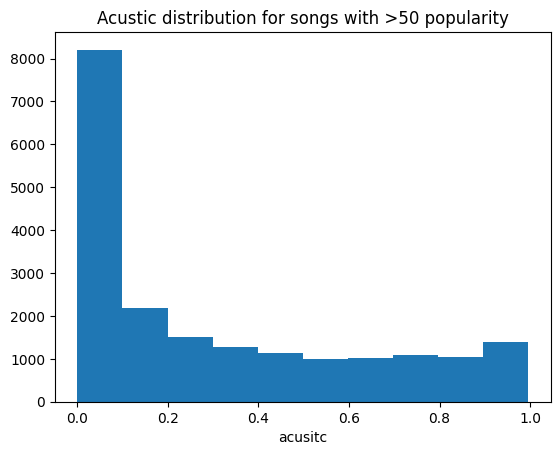

In [122]:
popular_songs = df[df.popularity > 50]
plt.hist(popular_songs["acousticness"])
plt.xlabel("acusitc")
plt.title("Acustic distribution for songs with >50 popularity")

Text(0.5, 1.0, 'danceability distribution for songs with > 0.7 dancability')

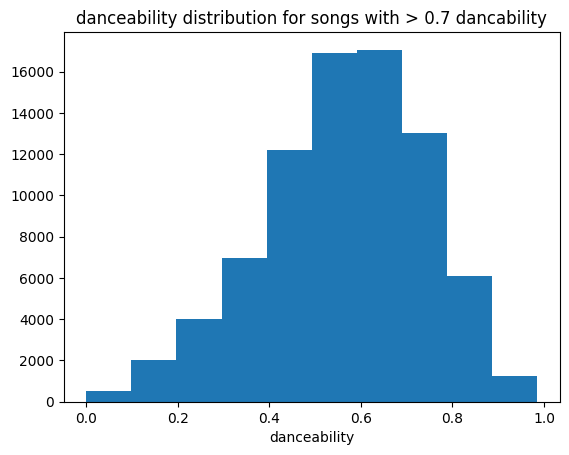

In [123]:
popular_songs = df[df.popularity > 0.7]
plt.hist(popular_songs["danceability"])
plt.xlabel("danceability")
plt.title("danceability distribution for songs with > 0.7 dancability")

C:\Users\Seojin Park\AppData\Local\Temp\ipykernel_25588\4226924672.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values="popularity", index="danceability_q", columns="energy_q", aggfunc="mean")


<Axes: xlabel='energy_q', ylabel='danceability_q'>

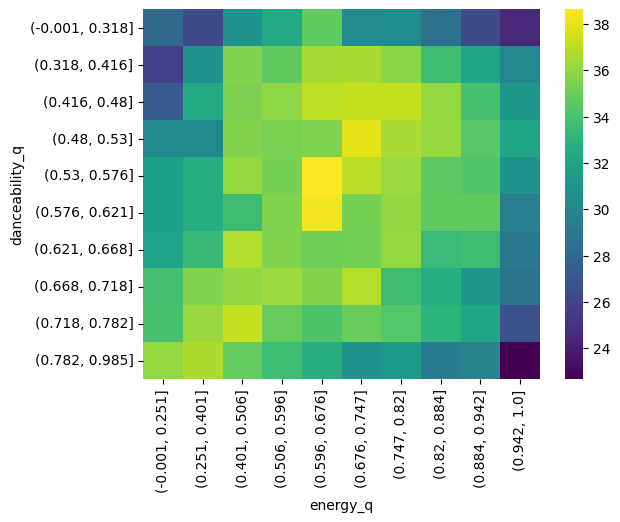

In [124]:
df["energy_q"] = pd.qcut(df["energy"], 10)
df["danceability_q"] = pd.qcut(df["danceability"], 10)
pivot = df.pivot_table(values="popularity", index="danceability_q", columns="energy_q", aggfunc="mean")
sns.heatmap(pivot, cmap="viridis")

In [125]:
#Average popularity per artist
artist_pop = df.groupby("artists")["popularity"].mean()


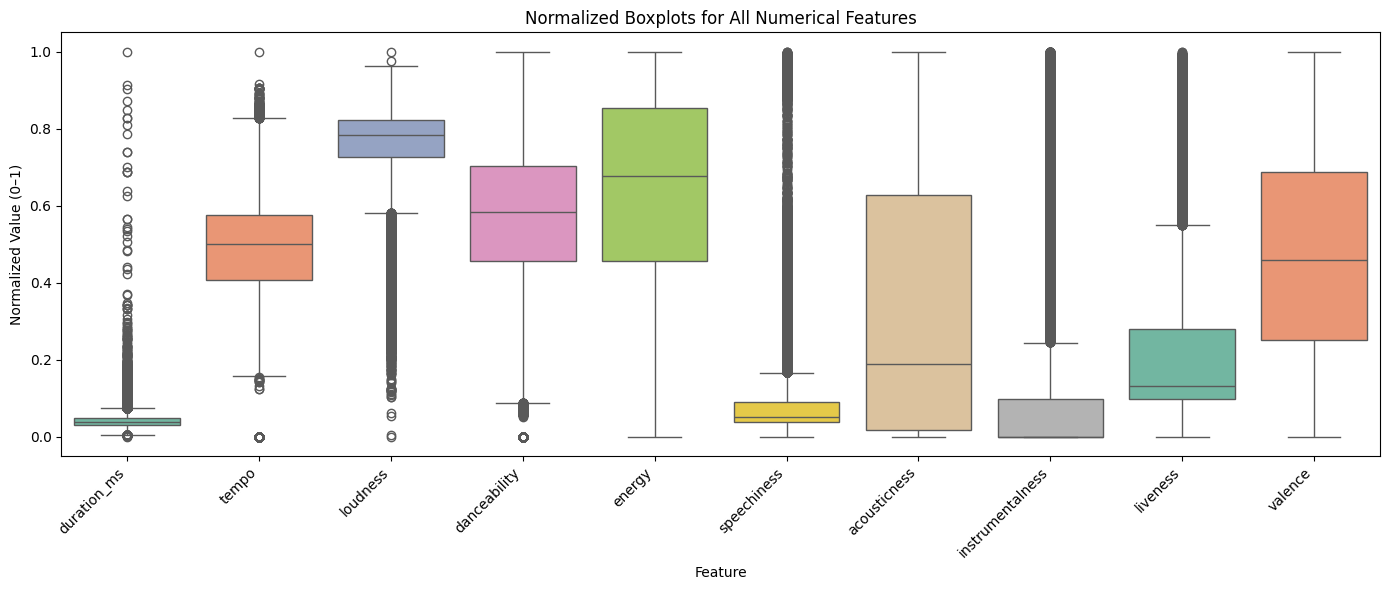

popularity
0      9367
21     2268
22     2248
20     2058
23     2031
       ... 
98        2
94        2
95        2
100       1
99        1
Name: count, Length: 101, dtype: int64


In [126]:
#normalize numerical columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_norm = df.copy()
numerical_columns.pop(0)
df_norm[numerical_columns] = scaler.fit_transform(df[numerical_columns])
plt.figure(figsize=(14, 6))

df_melted = df_norm[numerical_columns].melt(var_name="Feature", value_name="Normalized")
sns.boxplot(
    data=df_melted,
    x="Feature",
    y="Normalized",
    hue="Feature",       
    palette="Set2",
    dodge=False         
)
plt.xticks(rotation=45, ha="right")
plt.title("Normalized Boxplots for All Numerical Features")
plt.ylabel("Normalized Value (0–1)")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


print(df_norm["popularity"].value_counts())

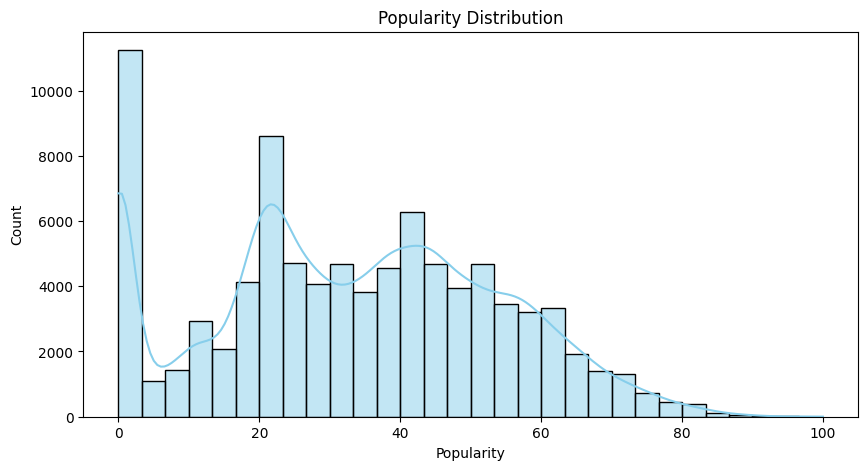

In [127]:
plt.figure(figsize=(10, 5))
sns.histplot(df['popularity'], bins=30, kde=True, color='skyblue')
plt.title('Popularity Distribution')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

## Feature Engineering & Model Training

In [128]:
"""
    feature engineering for popularity
"""
df_norm.loc[df_norm['popularity'] < 57, 'popularity'] = 0   # Low
# df_norm.loc[(df_norm['popularity'] >= 30) & (df_norm['popularity'] < 40), 'popularity'] = 1  # Medium
df_norm.loc[df_norm['popularity'] >= 57, 'popularity'] = 1  # High

df_norm['popularity'].value_counts()
df_norm.head()


,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,energy_q,danceability_q
0,Gen Hoshino,Comedy,Comedy,1,0.042473,0,0.686294,0.4610,1,0.791392,...,0.148187,0.032329,0.000001,0.3580,0.718593,0.361245,4,acoustic,"(0.401, 0.506]","(0.668, 0.718]"
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,0,0.026971,0,0.426396,0.1660,1,0.597377,...,0.079067,0.927711,0.000006,0.1010,0.268342,0.318397,4,acoustic,"(-0.001, 0.251]","(0.416, 0.48]"
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,1,0.038679,0,0.444670,0.3590,0,0.736123,...,0.057720,0.210843,0.000000,0.1170,0.120603,0.313643,4,acoustic,"(0.251, 0.401]","(0.416, 0.48]"
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,1,0.036978,0,0.270051,0.0596,0,0.573701,...,0.037617,0.908635,0.000071,0.1320,0.143719,0.746758,3,acoustic,"(-0.001, 0.251]","(-0.001, 0.318]"
4,Chord Overstreet,Hold On,Hold On,1,0.036389,0,0.627411,0.4430,2,0.737103,...,0.054508,0.470884,0.000000,0.0829,0.167839,0.492863,4,acoustic,"(0.401, 0.506]","(0.576, 0.621]"


In [129]:
df_norm['popularity'].value_counts()

popularity
0    76416
1    12963
Name: count, dtype: int64

In [130]:
len(df[df['popularity'] <= 57])

77541

In [131]:

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def feature(df, col):
    X = df[col].copy()
    y = df["popularity"].astype(int)
    return X, y

def precision_at_k(predictions, y_true, ks=[1, 100, 1000, 10000]):
    precs = []
    for K in ks:
        top_pred = predictions[:min(K, len(predictions))]
        # true positives: ground truth values at top predicted indices
        true_positives = np.sum(y_true[top_pred] == 1)
        precs.append(true_positives / len(top_pred))
    return precs

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def evaluate(model, X, y, name="set"):
    y_pred = model.predict(X)
    y_pred_class = np.round(y_pred).astype(int)
    print("accuarcy:", accuracy_score(y,y_pred_class))
    print(f"\n=== {name.upper()} ===")
    print("R²:", r2_score(y, y_pred))
    print("MAE:", mean_absolute_error(y, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
    print("MSE:", mse(y, y_pred))

In [132]:
import random
random.seed(0)       
df_shuffled = df_norm.sample(frac=1, random_state=0).reset_index(drop=True)

N = len(df_norm)

train_end = int(0.8 * N)
valid_end = int(0.9 * N)   # 50% + 25%

dataTrain = df_norm[:train_end]
dataValid = df_norm[train_end:valid_end]
dataTest  = df_norm[valid_end:]

dfTrain = pd.DataFrame(dataTrain)
dfValid = pd.DataFrame(dataValid)
dfTest  = pd.DataFrame(dataTest)

"""FROM LOG-SCALED HEATMAP
    explicit          binary (0-1)
    danceability      float64
    loudness          float64
    time_signature    int64 (0-4)
    energy            float64
    tempo             float64

    key               int64 (0-11) 
"""

heatmap_feat = [
    "explicit",
    "danceability",
    "loudness",
    "tempo",
    "energy",
    "time_signature",
    "speechiness",
    "liveness",
    "key",
    "acousticness",
]

all_feat = [
    "explicit",
    "danceability",
    "energy",
    "loudness",
    "tempo",
    "acousticness",
    "speechiness",
    "instrumentalness",
    "liveness",
    "valence",
    "duration_ms",
    "key",
    "mode",
    "time_signature"
]

X_train, y_train = feature(dfTrain, heatmap_feat) #50%
X_valid, y_valid = feature(dfValid, heatmap_feat) #25%
X_test,  y_test  = feature(dfTest, heatmap_feat)  #25%


In [133]:
print(df.columns)

Index(['artists', 'album_name', 'track_name', 'popularity', 'duration_ms',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre', 'energy_q',
       'danceability_q'],
      dtype='object')


In [134]:
""" LINEAR REGRESSION
"""

from sklearn.linear_model import LinearRegression

# fit linear regression
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)

#evaluate
# Validation performance
evaluate(linearModel, X_valid, y_valid, "validation")

# Test performance
evaluate(linearModel, X_test, y_test, "test")

accuarcy: 0.8889013202058627

=== VALIDATION ===
R²: -0.03024762465766817
MAE: 0.22183583761676615
RMSE: 0.3189716137816061
MSE: 0.1017428903984421
accuarcy: 0.8986350413962855

=== TEST ===
R²: -0.0458477575873919
MAE: 0.22856638144436073
RMSE: 0.30865252431704504
MSE: 0.09526638076728408


In [135]:
""" RIDGE REGRESSION
    Linear regression is performing badly, (negative R2 score)
    Try accounting for corrolation in data

    Bad features
"""

from sklearn.linear_model import Ridge

# Fit Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predictions
y_pred_valid = ridge.predict(X_valid)
y_pred_test  = ridge.predict(X_test)

# Evaluate on validation
evaluate(ridge, X_valid, y_valid, "Ridge Regression - Validation")

# Evaluate on test
evaluate(ridge, X_test, y_test, "Ridge Regression - Test")


accuarcy: 0.8889013202058627

=== RIDGE REGRESSION - VALIDATION ===
R²: -0.02996827942105562
MAE: 0.2217882555161938
RMSE: 0.3189283672651592
MSE: 0.1017153034464203
accuarcy: 0.8986350413962855

=== RIDGE REGRESSION - TEST ===
R²: -0.045720791622275936
MAE: 0.228543536043029
RMSE: 0.30863378853318424
MSE: 0.09525481542434627


In [136]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
# Evaluate on validation
evaluate(xgb_model, X_valid, y_valid, "xgb Regression - Validation")

# Evaluate on test
evaluate(xgb_model, X_test, y_test, "xgb - Test")

accuarcy: 0.8842022823897964

=== XGB REGRESSION - VALIDATION ===
R²: -0.1725666829543746
MAE: 0.11579771761020362
RMSE: 0.3402906369711098
MSE: 0.11579771761020362
accuarcy: 0.8940478854329827

=== XGB - TEST ===
R²: -0.16315724958884115
MAE: 0.10595211456701722
RMSE: 0.32550286414564344
MSE: 0.10595211456701722


In [137]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [139]:
from sklearn.metrics import accuracy_score, classification_report 

def eval_classification(model, X, y, name="set"):
    y_pred = model.predict(X)
    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

eval_classification(rf_model, X_train, y_train, "train")
eval_classification(rf_model, X_valid, y_valid, "valid")
eval_classification(rf_model, X_test,  y_test,  "test")


=== TRAIN ===
Accuracy: 0.9937065577668069

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     60439
           1       1.00      0.96      0.98     11064

    accuracy                           0.99     71503
   macro avg       0.99      0.98      0.99     71503
weighted avg       0.99      0.99      0.99     71503


=== VALID ===
Accuracy: 0.8853211009174312

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7945
           1       0.17      0.01      0.02       993

    accuracy                           0.89      8938
   macro avg       0.53      0.50      0.48      8938
weighted avg       0.81      0.89      0.84      8938


=== TEST ===
Accuracy: 0.8976281047214142

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8032
           1       0.36      0.01 

In [181]:

print(len(df[df.popularity == 0]))
print(len(df[df.popularity == 1]))
print(len(df[df.popularity == 2]))
df_norm['popularity'].value_counts()


16019
2140
1036


popularity
0    50486
2    48587
1    14926
Name: count, dtype: int64

## Model Evaluation